In [1]:
import numpy as np
import json, pickle
import re, os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def load_json(path):
    with open(path, 'r', encoding='utf-8') as fr:
        data_json = json.load(fr)
    fr.close()
    return data_json

def save_json(obj, path):
    with open(path, 'w') as outfile:
        json.dump(obj, outfile, indent=2)

def save_parameter(save_object, save_file):
    with open(save_file, 'wb') as f:
        pickle.dump(save_object, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_parameter(load_file):
    with open(load_file, 'rb') as f:
        output = pickle.load(f)
    return output

def clean_text(text):
    pattern = r"\W+"
    text = re.sub(pattern, " ", text)
    text = text.lower()
    return text

# EDA

Vì có một số các điều luật bị rỗng, để đảm bảo cho các điều luật được thực hiện word segmentation mà không bị lỗi. Ngoài ra các lỗi này còn sảy ra gồm nhiều khả năng như chứa các ký tự đặc biệt mà VnCoreNLP không thực hiện segment được, hoặc một lý do tâm linh nào đó!!!

Do vậy, cần concat phần 'title' và 'text' của điều luật để giảm thiểu khả năng gây lỗi trong quá trình thực hiện segmentation


In [3]:
data = load_json("./zalo_datasets/legal_corpus.json")
training_corpus = [clean_text(article["title"] + " " + article["text"])\
                   for doc in data for article in doc["articles"]]

Sau khi concat các title và text, số lượng điều luật trống trở thành 0

In [4]:
empty_ids = [idx for idx, sent in enumerate(training_corpus) if len(sent)==0]
print(f"Total of empty articles: {len(empty_ids)}")

Total of empty articles: 0


In [5]:
num_tokens = [len(sent.split()) for sent in training_corpus]

Độ dài của các điều luật trong tập corpus được phân phối theo hình bên dưới. Đa số các điều luật có độ dài (số lượng từ) lớn hơn 2000 là rất ít, còn lại là nhỏ hơn 2000. Do vậy, có thể lựa chọn số lượng tokens tối đa cho mô hình huấn luyện phù hợp, dựa vào điều này

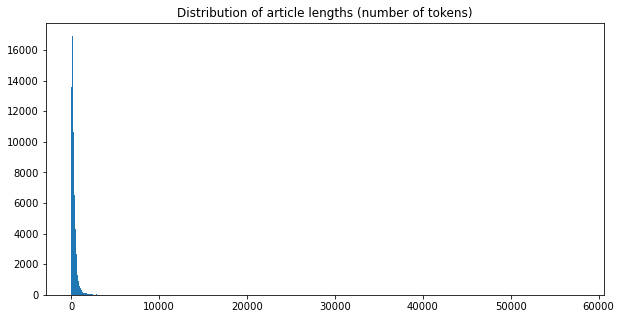

In [6]:
fig = plt.figure(figsize=(10,5))
plt.hist(num_tokens, bins=600)
plt.title("Distribution of article lengths (number of tokens)")
plt.show()

In [7]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

In [8]:
word_tokenizer = AutoTokenizer.from_pretrained("vinai/bartpho-word")
syllable_tokenizer = AutoTokenizer.from_pretrained("vinai/bartpho-syllable")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
syllable_tokenizer.convert_tokens_to_ids("<mask>")

40029

In [10]:
from vncorenlp import VnCoreNLP
annotator = VnCoreNLP(
        "./VnCoreNLP/VnCoreNLP-1.1.1.jar", 
        annotators="wseg,pos,ner,parse", 
        max_heap_size="-Xmx2g"
    )

In [11]:
sent = training_corpus[10]

In [12]:
seg_sent = ' '.join(annotator.tokenize(sent)[0])

In [14]:
print(sent)
print()
print(seg_sent)

điều 11 nội dung tuần tra canh gác kè bảo vệ đê 1 khi mái kè chưa bị ngập nước a kiểm tra mái kè quan sát dòng chảy khu vực kè b nếu phát hiện thấy hư hỏng phải xác định vị trí loại hư hỏng đặc điểm và kích thước hư hỏng mực nước sông so với đỉnh kè đánh dấu bằng cách ghi bảng cắm tiêu bảng báo hiệu vị trí hư hỏng thường xuyên theo dõi diễn biến của hư hỏng báo cáo kịp thời và cụ thể tình hình hư hỏng cho đội trưởng đội phó cán bộ chuyên trách quản lý đê điều và ban chỉ huy phòng chống lụt bão xã 2 khi kè bị ngập nước a tại những kè xung yếu khi nước chưa ngập đỉnh kè đội tuần tra canh gác đê có nhiệm vụ cắm các hàng tiêu để quan sát sự xói lở của kè các hàng tiêu có thể được cắm như sau cắm tiêu dọc theo kè cách đỉnh kè 01 mét và vượt quá đầu và đuôi kè từ 20 mét đến 30 mét những vị trí xung yếu của kè cắm ít nhất từ 02 hàng tiêu trở lên khoảng cách giữa các tiêu từ 03 mét đến 04 mét hàng nọ cách hàng kia từ 02 mét đến 2 5 mét tiêu cắm so le nhau tiêu có thể được làm bằng tre nứa hoặc

In [15]:
word_encodings = word_tokenizer(seg_sent, return_tensors="pt")
syllable_encodings = syllable_tokenizer(sent, return_tensors="pt")

In [33]:
dep_out = annotator.dep_parse(sent)

In [34]:
dep_out

[[('sub', 119, 1),
  ('det', 3, 2),
  ('nmod', 1, 3),
  ('nmod', 3, 4),
  ('vmod', 4, 5),
  ('vmod', 4, 6),
  ('nmod', 6, 7),
  ('dob', 7, 8),
  ('det', 8, 9),
  ('tmp', 4, 10),
  ('sub', 14, 11),
  ('nmod', 11, 12),
  ('adv', 14, 13),
  ('nmod', 10, 14),
  ('vmod', 14, 15),
  ('dob', 15, 16),
  ('nmod', 16, 17),
  ('vmod', 17, 18),
  ('dob', 18, 19),
  ('nmod', 19, 20),
  ('nmod', 19, 21),
  ('nmod', 19, 22),
  ('nmod', 22, 23),
  ('nmod', 23, 24),
  ('loc', 24, 25),
  ('dep', 27, 26),
  ('xadv', 25, 27),
  ('vmod', 27, 28),
  ('vmod', 28, 29),
  ('vmod', 29, 30),
  ('vmod', 30, 31),
  ('dob', 31, 32),
  ('nmod', 32, 33),
  ('nmod', 32, 34),
  ('amod', 34, 35),
  ('coord', 35, 36),
  ('conj', 36, 37),
  ('nmod', 37, 38),
  ('dob', 38, 39),
  ('nmod', 39, 40),
  ('nmod', 39, 41),
  ('nmod', 35, 42),
  ('vmod', 42, 43),
  ('pob', 43, 44),
  ('nmod', 44, 45),
  ('prp', 31, 46),
  ('mnr', 46, 47),
  ('pob', 47, 48),
  ('nmod', 48, 49),
  ('dob', 49, 50),
  ('nmod', 50, 51),
  ('vmod', 51,

In [32]:
syllable_tokenizer.convert_ids_to_tokens(syllable_encodings["input_ids"][0])

['<s>',
 '▁điều',
 '▁11',
 '▁nội',
 '▁dung',
 '▁tuần',
 '▁tra',
 '▁can',
 'h',
 '▁gá',
 'c',
 '▁k',
 'è',
 '▁bảo',
 '▁vệ',
 '▁đê',
 '▁1',
 '▁khi',
 '▁mái',
 '▁k',
 'è',
 '▁chưa',
 '▁bị',
 '▁ngập',
 '▁nước',
 '▁a',
 '▁kiểm',
 '▁tra',
 '▁mái',
 '▁k',
 'è',
 '▁quan',
 '▁sát',
 '▁dòng',
 '▁chảy',
 '▁khu',
 '▁vực',
 '▁k',
 'è',
 '▁b',
 '▁nếu',
 '▁phát',
 '▁hiện',
 '▁thấy',
 '▁hư',
 '▁hỏng',
 '▁phải',
 '▁xác',
 '▁định',
 '▁vị',
 '▁trí',
 '▁loại',
 '▁hư',
 '▁hỏng',
 '▁đặc',
 '▁điểm',
 '▁và',
 '▁kích',
 '▁thước',
 '▁hư',
 '▁hỏng',
 '▁mực',
 '▁nước',
 '▁sông',
 '▁so',
 '▁với',
 '▁đỉnh',
 '▁k',
 'è',
 '▁đánh',
 '▁dấu',
 '▁bằng',
 '▁cách',
 '▁ghi',
 '▁bảng',
 '▁c',
 'ắ',
 'm',
 '▁tiêu',
 '▁bảng',
 '▁báo',
 '▁hiệu',
 '▁vị',
 '▁trí',
 '▁hư',
 '▁hỏng',
 '▁thường',
 '▁xuyên',
 '▁theo',
 '▁dõi',
 '▁diễn',
 '▁biến',
 '▁của',
 '▁hư',
 '▁hỏng',
 '▁báo',
 '▁cáo',
 '▁kịp',
 '▁thời',
 '▁và',
 '▁cụ',
 '▁thể',
 '▁tình',
 '▁hình',
 '▁hư',
 '▁hỏng',
 '▁cho',
 '▁đội',
 '▁trưởng',
 '▁đội',
 '▁phó',
 '▁cán',
 '▁bộ

In [30]:
print(ord('▁'))

9601


In [31]:
print(ord('_'))

95


In [1]:
def extract_features( document ):
    terms = tuple(document.lower().split())
    features = set()
    for i in range(len(terms)):
        for n in range(1,4):
            if i+n <= len(terms):
                features.add(terms[i:i+n])
    return features

documents = [
   "This article is about the Golden State Warriors",
   "This article is about the Golden Arches",
   "This article is about state machines",
   "This article is about viking warriors"]

def calc_idf(documents):
    
def calculate_idf( documents ):
    N = len(documents)
    from collections import Counter
    tD = Counter()
    for d in documents:
        features = extract_features(d)
        for f in features:
            tD[" ".join(f)] += 1
    IDF = []
    import math
    for (term,term_frequency) in tD.items():
        term_IDF = math.log(float(N) / term_frequency)
        IDF.append(( term_IDF, term ))
    IDF.sort(reverse=True)
    return IDF


In [2]:
for (IDF, term) in calculate_idf(documents):
    print(IDF, term)

1.3862943611198906 viking warriors
1.3862943611198906 viking
1.3862943611198906 the golden state
1.3862943611198906 the golden arches
1.3862943611198906 state warriors
1.3862943611198906 state machines
1.3862943611198906 machines
1.3862943611198906 is about viking
1.3862943611198906 is about state
1.3862943611198906 golden state warriors
1.3862943611198906 golden state
1.3862943611198906 golden arches
1.3862943611198906 arches
1.3862943611198906 about viking warriors
1.3862943611198906 about viking
1.3862943611198906 about state machines
1.3862943611198906 about state
0.6931471805599453 warriors
0.6931471805599453 the golden
0.6931471805599453 the
0.6931471805599453 state
0.6931471805599453 is about the
0.6931471805599453 golden
0.6931471805599453 about the golden
0.6931471805599453 about the
0.0 this article is
0.0 this article
0.0 this
0.0 is about
0.0 is
0.0 article is about
0.0 article is
0.0 article
0.0 about
